In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import gzip

import warnings
warnings.filterwarnings("ignore")

import io
from pysam import VariantFile

from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve

In [2]:
def read_vcf(path):
    if not os.path.exists(path) and os.path.exists(path+'.gz'):
        fp = open(path, "wb")
        with gzip.open(path+'.gz', "rb") as f:
            bindata = f.read()
        fp.write(bindata)
        fp.close()
    if os.path.exists(path):
        with open(path, 'r') as f:
            lines = [l for l in f if not l.startswith('##')]
        res = pd.read_csv(
            io.StringIO(''.join(lines)),
            dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                   'QUAL': str, 'FILTER': str, 'INFO': str},
            sep='\t'
        ).rename(columns={'#CHROM': 'CHROM'})
        return res

foo = lambda x: pd.Series(x.split('CALLERS=')[1].split(';')[0])

In [3]:
context = 'talk' # talk or paper

if context == 'talk':
    sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5,'font.size': 30})
    sns.set_palette("deep")
else:
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 1, "legend.fontsize":10})
    plt.rcParams.update({'font.size': 15})
    sns.set_palette("deep")

lc = 'w' if context == 'talk' else 'k'

In [4]:
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
nmethods = len(methods)

In [5]:
tab20 = cm.get_cmap('tab10', 8)
newcmap_list = []
for i in range(4):
    newcmap_list.append(tab20.colors[i])
for i in range(4):
    newcmap_list.append(np.array(list(tab20.colors[i][:-1]) +[0.3]))

newcmap = ListedColormap(newcmap_list, name='newcmap')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [6]:
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]
alpha_list = [1, 1, .8, .6, .4, .2, 0.1]

# Select plasma sample and reference

In [36]:
#sample = '809'
sample = '986'
#sample = '1014'
#reference = 'pooledhealthy_986_filter_snv'
reference = 'pooledhealthy'
#reference = 'lowtb'

In [37]:
if sample == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
elif sample == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
elif sample == '1014':
    plasmasample1 = 'CRC-1014_180816'
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None

In [38]:
if reference == 'lowtb':
    if sample == '986':
        reference = 'CRC-986_300316'
    elif sample == '809':
        raise ValueError('no matched low tb sample')
    elif sample == '1014':
        reference = 'CRC-1014_090516'

print(reference) # pooledhealthy if not lowtb

pooledhealthy


# Load SNV calls
## Calls of dilution series

In [39]:
vcf_pd_dict = {}
samples_dict = {}

ci = 0
dilutionseries_new = []

for i, d in enumerate(dilutionseries):
    print('vcf_pd_'+str(ci), d)
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    if d == (1,0):
        vcf_path = os.path.join("..","data","bcbio_output", "dilution_chr22_"+plasmasample1+"_1_pooledhealthy_0",
                                                        "dilution_chr22_"+plasmasample1+"_1_pooledhealthy_0-ensemble-annotated.vcf")
    else:
        vcf_path = os.path.join("..","data","bcbio_output", "dilution_chr22_"+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]),
                                                        "dilution_chr22_"+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    if os.path.exists(vcf_path) or os.path.exists(vcf_path+'.gz'):
        vcf_pd_dict['vcf_pd_'+str(ci)] = read_vcf(vcf_path)

        #if i == 0:
        #    print(vcf_pd_dict['vcf_pd_'+str(i)].head())

        vcf_pd_dict['vcf_pd_'+str(ci)]['callers'] = vcf_pd_dict['vcf_pd_'+str(ci)]['INFO'].apply(foo)
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'] = np.nan
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(ci)]['REF'].str.len() == 0] = 'SNV'
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(ci)]['REF'].str.len() > 0] = 'INS'
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(ci)]['REF'].str.len() < 0] = 'DEL'
        vcf_pd_dict['vcf_pd_'+str(ci)]['type'][vcf_pd_dict['vcf_pd_'+str(ci)]['ID'].str.contains('rs')] = 'SNP'
        for m in methods:
            vcf_pd_dict['vcf_pd_'+str(ci)][m] = vcf_pd_dict['vcf_pd_'+str(ci)]['INFO'].str.contains(m)
            
        sample = vcf_pd_dict['vcf_pd_'+str(ci)][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
        sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
        sample.set_index('CHROM_POS', inplace = True)
        sample = sample[sample['CHROM'] == '22']
        samples_dict['sample_'+str(ci)] = sample
        
        ci += 1
        dilutionseries_new.append(d)
    else:
        print("dilution {} is not present with path {}".format(d, vcf_path))

nsamples = len(vcf_pd_dict.keys())
vcf_pd_dict['vcf_pd_'+str(nsamples-1)].head()

vcf_pd_0 (1, 0)
vcf_pd_1 (1, 0.72)
vcf_pd_2 (0.75, 0.765)
vcf_pd_3 (0.5, 0.81)
dilution (0.5, 0.81) is not present with path ../data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_3 (0.25, 0.855)
vcf_pd_4 (0.125, 0.875)


CHROM       POS           ID REF ALT   QUAL FILTER  \
0    22  16050252  rs199856444   A   T  377.4   PASS   
1    22  16050353   rs56342815   G   T  115.0   PASS   
2    22  16050455            .   T   C   82.0   PASS   
3    22  16050822   rs12172168   G   A    0.0   PASS   
4    22  16050922  rs367963583   T   G    0.0   PASS   

                                                INFO  \
0  AB=0.201493;ABP=210.435;AC=1;AF=0.25;AN=4;AO=5...   
1  AF=0.0124;CALLERS=vardict,varscan;DP=564;LSEQ=...   
2  AF=0.0105;CALLERS=vardict;DP=382;LSEQ=TCCTTAGT...   
3  CALLERS=mutect2,vardict,varscan;ClippingRankSu...   
4  CALLERS=mutect2,vardict,varscan;ClippingRankSu...   

                                              FORMAT  \
0                         GT:AD:AO:DP:GQ:PL:QA:QR:RO   
1  GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...   
2  GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...   
3                                        GT:AD:AF:DP   
4                                        GT:AD:AF:DP   

  dilution_chr22_CRC-986_100215_0_125_pooledhealthy_0_875-T  \
0      0/1:213,54:54:268:99:623,0,4679:2139:8232:213          
1  0/1:556,7:0:0.0124:3,4:2,2:564:0.0127:25.3:1.3...          
2  0/1:378,4:0:0.0105:0,4:2,0:382:0.0106:25.5:1:0...          
3                               0/1:203,21:0.095:224          
4                               0/1:453,16:0.032:469          

  dilution_chr22_CRC-986_100215_0_125_pooledhealthy_0_875-N  \
0                 0/0:16,0:0:16:52:0,48,464:0:616:16          
1  0/0:35,0:0:0:0,0:2,0:35:1:52.1:0.3:0:34.7:1:1:...          
2  0/0:31,0:0:0:0,0:2,0:31:1:47.9:0.3:0:31.5:1:1:...          
3                                      0/0:30,0:0:30          
4                                      0/0:54,0:0:54          

                   callers type  freebayes  mutect2  strelka2  vardict  \
0        freebayes,vardict  SNP       True    False     False     True   
1          vardict,varscan  SNP      False    False     False     True   
2                  vardict  SNV      False    False     False     True   
3  mutect2,vardict,varscan  SNP      False     True     False     True   
4  mutect2,vardict,varscan  SNP      False     True     False     True   

   varscan  
0    False  
1     True  
2    False  
3     True  
4     True

In [40]:
print(vcf_pd_dict.keys())
samples = list(samples_dict.values())

dict_keys(['vcf_pd_0', 'vcf_pd_1', 'vcf_pd_2', 'vcf_pd_3', 'vcf_pd_4'])


## Calls of second plasma sample

In [41]:
vcf_path = os.path.join("..","data","bcbio_output", 'dilution_chr22_'+plasmasample2+'_1_pooledhealthy_0',
                                                    'dilution_chr22_'+plasmasample2+"_1_pooledhealthy_0-ensemble-annotated.vcf")
if os.path.exists(vcf_path) or os.path.exists(vcf_path+'.gz'):
    vcf_pd_dict['vcf_pd_0_bis'] = read_vcf(vcf_path)
    
    vcf_pd_dict['vcf_pd_0_bis']['callers'] = vcf_pd_dict['vcf_pd_0_bis']['INFO'].apply(foo)
    vcf_pd_dict['vcf_pd_0_bis']['type'] = np.nan
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() == 0] = 'SNV'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() > 0] = 'INS'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() < 0] = 'DEL'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ID'].str.contains('rs')] = 'SNP'
    for m in methods:
        vcf_pd_dict['vcf_pd_0_bis'][m] = vcf_pd_dict['vcf_pd_0_bis']['INFO'].str.contains(m)
        
    sample = vcf_pd_dict['vcf_pd_0_bis'][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
    sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
    sample.set_index('CHROM_POS', inplace = True)
    sample = sample[sample['CHROM'] == '22']
    samples_dict['sample_0_bis'] = sample

    l1 = list(samples_dict['sample_0'].index)
    l2 = list(samples_dict['sample_0_bis'].index)
    print(len(l1), len(l2))
    print(len(list(set(set(l1) & set(l2)))))

24729 18011
4368


In [42]:
l2 = list(samples_dict['sample_0_bis'].index)
print(len(l2))

18011


## Calls of matched tumor

In [43]:
vcf_path = os.path.join("..","data","bcbio_output", tumorsample1, tumorsample1+"-ensemble-annotated.vcf")
if os.path.exists(vcf_path) or os.path.exists(vcf_path+'.gz'):
    vcf_pd_dict['vcf_pd_t'] = read_vcf(vcf_path)
    
    vcf_pd_dict['vcf_pd_t']['callers'] = vcf_pd_dict['vcf_pd_t']['INFO'].apply(foo)
    vcf_pd_dict['vcf_pd_t']['type'] = np.nan
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() == 0] = 'SNV'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() > 0] = 'INS'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() < 0] = 'DEL'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ID'].str.contains('rs')] = 'SNP'
    for m in methods:
        vcf_pd_dict['vcf_pd_t'][m] = vcf_pd_dict['vcf_pd_t']['INFO'].str.contains(m)
        
    sample = vcf_pd_dict['vcf_pd_t'][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
    sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
    sample.set_index('CHROM_POS', inplace = True)
    sample = sample[sample['CHROM'] == '22']
    samples_dict['sample_t'] = sample
    
l1 = list(samples_dict['sample_t'].index)
l2 = list(samples_dict['sample_0'].index)
print(len(l1), len(l2))
print(len(list(set(set(l1) & set(l2)))))

703 24729
230


# Estimated tumor burden of mixed samples

In [44]:
samples_tf = {}
for i in range(nsamples):
    samples_tf['sample_'+str(i)] = float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0])
print(samples_tf)

{'sample_0': 0.41899930338493496, 'sample_1': 0.08332118791365564, 'sample_2': 0.06246857187258912, 'sample_3': 0.02080792450423319, 'sample_4': 0.01043106660067952}


# Depth of coverage of mixed samples

{'sample_0': [50.2097, 0.41899930338493496], 'sample_1': [338.854, 0.08332118791365564], 'sample_2': [344.346, 0.06246857187258912], 'sample_3': [355.321, 0.02080792450423319], 'sample_4': [357.07, 0.01043106660067952]}


average depth of coverage  tumor burden
sample_0                    50.2097         41.90
sample_1                   338.8540          8.33
sample_2                   344.3460          6.25
sample_3                   355.3210          2.08
sample_4                   357.0700          1.04

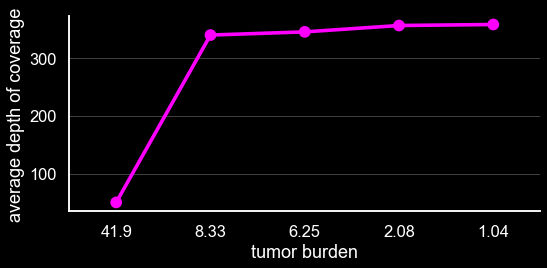

In [45]:
samples_cov = {}
for i in range(nsamples):
    ## OLD TO UPDATE
    samples_cov['sample_'+str(i)] = [float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "coverage_chr22_"+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0]),
                                     float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0])]
print(samples_cov)


coverage_pd = pd.DataFrame.from_dict(samples_cov).T
coverage_pd.columns = ['average depth of coverage', 'tumor burden']
coverage_pd['tumor burden'] = 100*coverage_pd['tumor burden']
coverage_pd = coverage_pd.round({'tumor burden': 2}) 
sns.factorplot(x='tumor burden', y='average depth of coverage', data=coverage_pd,
            order=sorted(coverage_pd['tumor burden'].unique(), reverse=True), color='magenta', size=4, aspect=2)
        
coverage_pd

# Number of detections detected

In [46]:
samples = list(samples_dict.values())[:nsamples]
len(samples)

5

          freebayes  mutect2  strelka2  vardict  varscan
0.418999       1023      257       633    14107    10128
0.083321      25063    32621     35380   108175    99901
0.062469      25912    33282     36291   106493   100288
0.020808      27436    34032     37985   105481   100032
0.010431      27820    34275     38445   104494   100209
          freebayes  mutect2  strelka2  vardict  varscan
0.418999        115       18        29     6560     2295
0.083321        212      340        56    14463     6139
0.062469        210      342        57    13111     6172
0.020808        222      381        77    11494     6214
0.010431        222      389        81    10788     6272
          freebayes  mutect2  strelka2  vardict  varscan
0.418999        343       88       310     6402     3961
0.083321        160      784       215    15267    15340
0.062469        159      845       231    14063    14957
0.020808        156     1038       238    12676    14035
0.010431        161     1048   

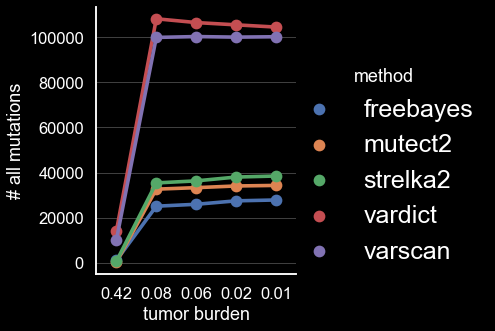

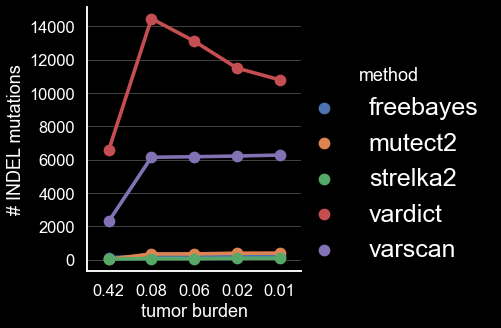

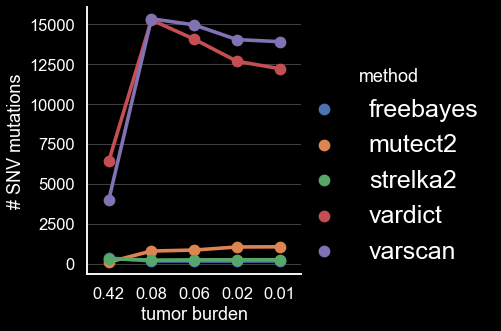

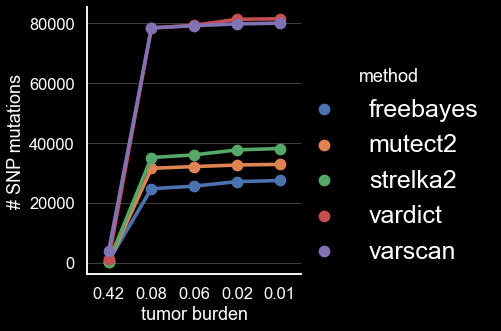

In [47]:
for mutationtype in ['all', 'INDEL', 'SNV', 'SNP']:
    numbersnvs_pd = pd.DataFrame()

    for si, s in enumerate(samples):
        nb_snv = []
        for method in methods:
            if mutationtype == 'all':
                nb_snv.append(s[s[method] == True].shape[0])
            elif mutationtype == 'INDEL':
                nb_snv.append(s[(s[method] == True) & ((s['type'] == 'INS') | (s['type'] == 'DEL'))].shape[0])
            elif mutationtype == 'SNV':
                nb_snv.append(s[(s[method] == True) & (s['type'] == 'SNV')].shape[0])
            elif mutationtype == 'SNP':
                nb_snv.append(s[(s[method] == True) & (s['type'] == 'SNP')].shape[0])
            else:
                raise ValueError('mutation type {} unknown'.format(mutationtype))
        if si == 0:
            numbersnvs_pd = pd.DataFrame.from_dict({'sample_'+ str(si): nb_snv}).T
            numbersnvs_pd.columns = methods
        else:
            numbersnvs_pd.loc['sample_'+ str(si)] = nb_snv
        numbersnvs_pd = numbersnvs_pd.rename(index=samples_tf)

    numbersnvs_pd_aux = numbersnvs_pd.reset_index()
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = pd.melt(numbersnvs_pd_aux, id_vars=['tumor burden'], value_vars=methods, var_name='method', value_name='# '+ mutationtype +' mutations')
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = numbersnvs_pd_aux.round({'tumor burden': 2}) 
    sns.catplot(x='tumor burden', y='# '+ mutationtype +' mutations', kind='point', data=numbersnvs_pd_aux, hue='method',
               order=sorted(numbersnvs_pd_aux['tumor burden'].unique(), reverse=True), title=mutationtype)

    print(numbersnvs_pd)

In [48]:
len(samples)

5

# Within caller consistency with original Plasma Sample as reference

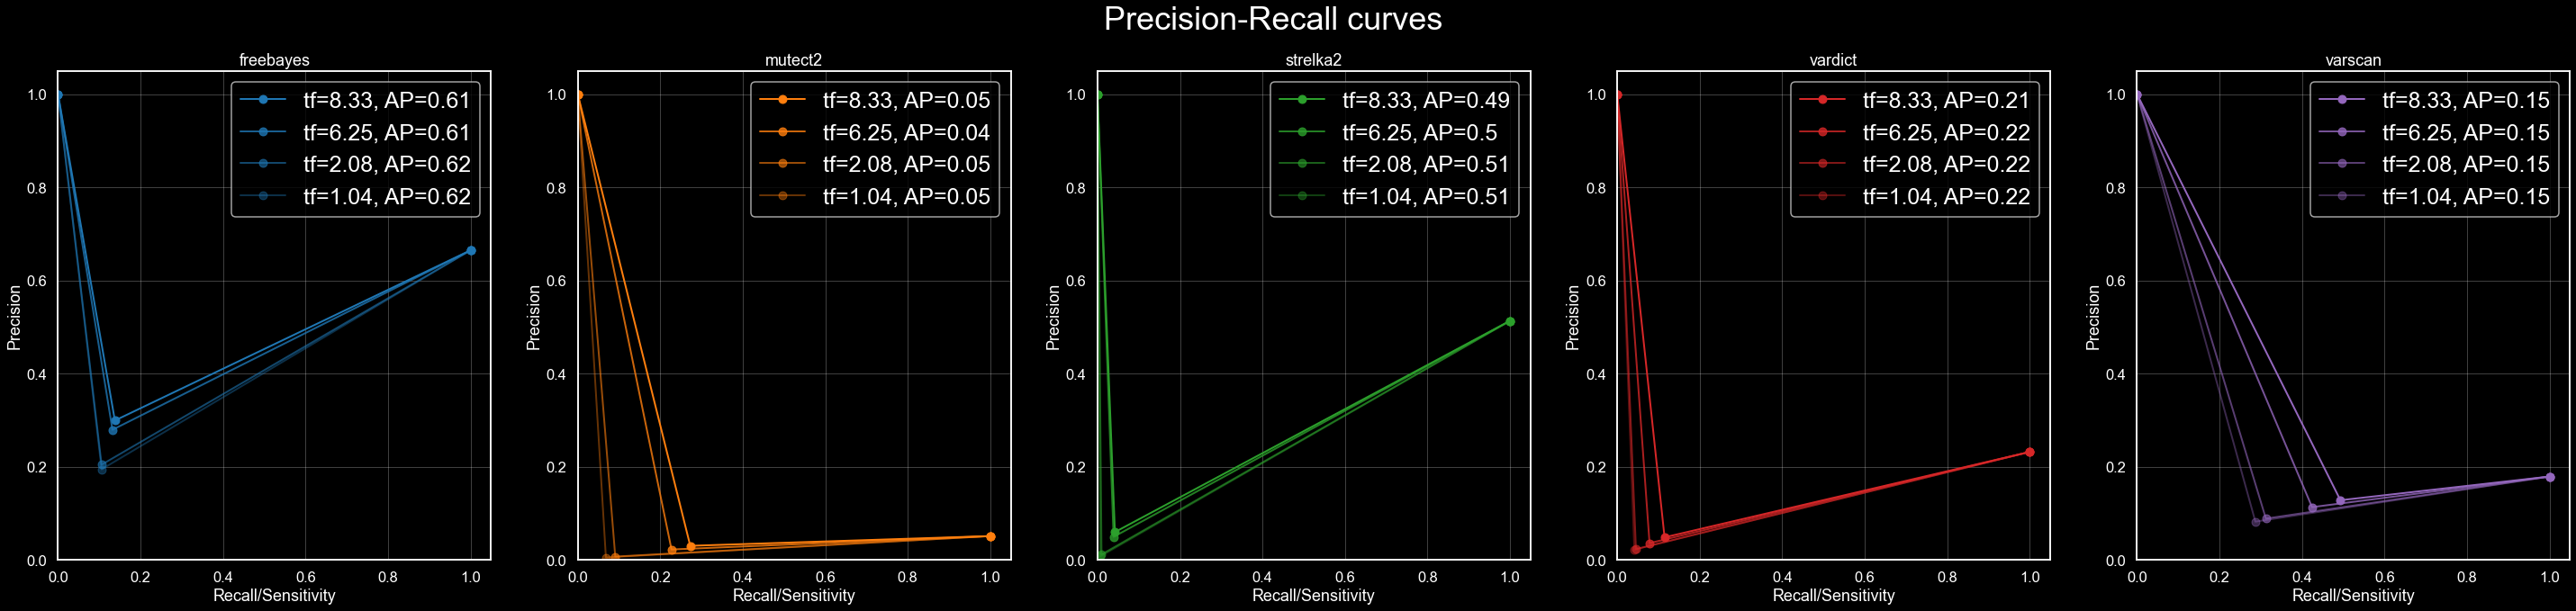

<Figure size 432x288 with 0 Axes>

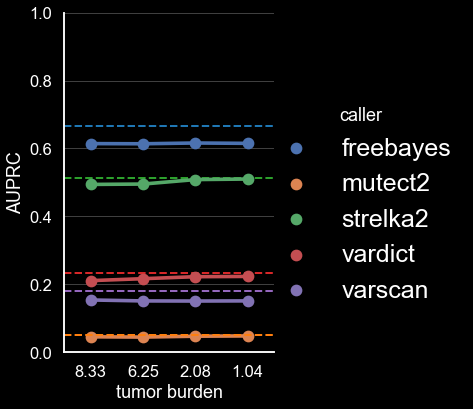

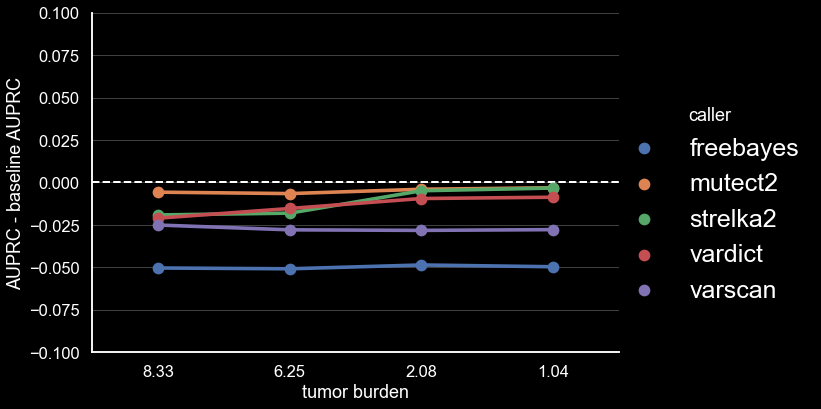

<Figure size 432x288 with 0 Axes>

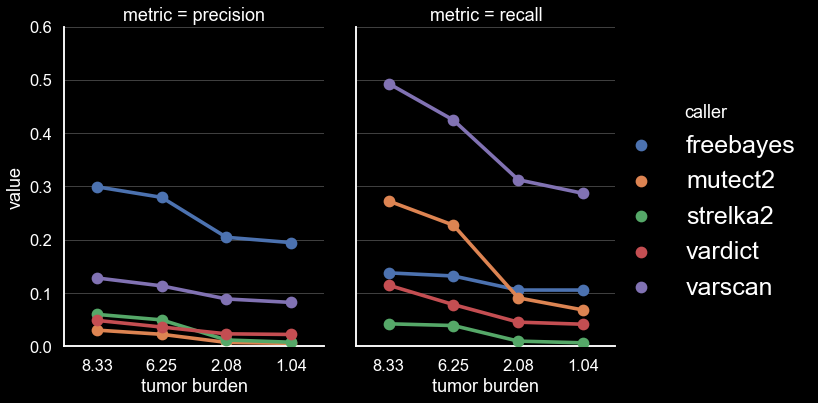

In [49]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        
        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

In [111]:
for mutation in ['snv']: #, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    count = 0

    y_series_list = []

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)
        
        y_series = pd.concat(y_list[1:], axis=1)
        y_series.insert(0, 'ref', y_true)
        #y_series['ref'] = y_true
        y_series_list.append(y_series.T)
    
    y_series_all = pd.concat(y_series_list, keys=methods)
    #y_series.sort_index(inplace=True)
    #plt.figure()
    #sns.heatmap(y_series, cbar="coolwarm")
    #plt.title(mutation + ' ' + method)
    #plt.show()

In [112]:
y_series_list[0].T

ref  sample_1  sample_2  sample_3  sample_4
22_16228097   True     False     False     False     False
22_16357562   True     False     False     False     False
22_16549560   True     False     False     False     False
22_16549595   True      True      True     False     False
22_16549601   True     False     False     False     False
...            ...       ...       ...       ...       ...
22_50769144  False     False     False      True      True
22_51031808  False     False     False      True      True
22_18721083  False     False     False     False      True
22_25107793  False     False     False     False      True
22_40016092  False     False     False     False      True

[513 rows x 5 columns]

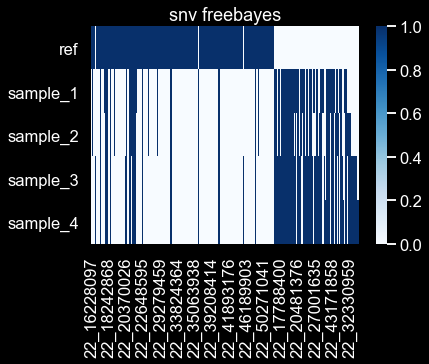

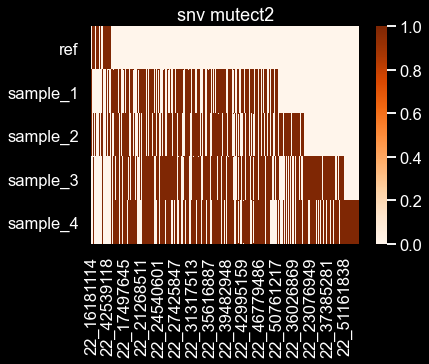

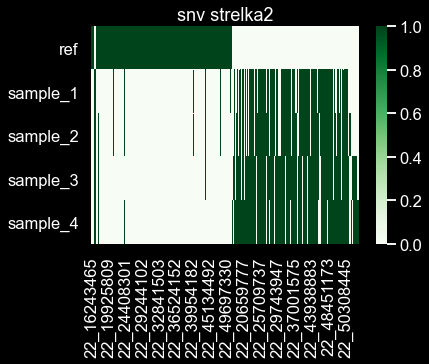

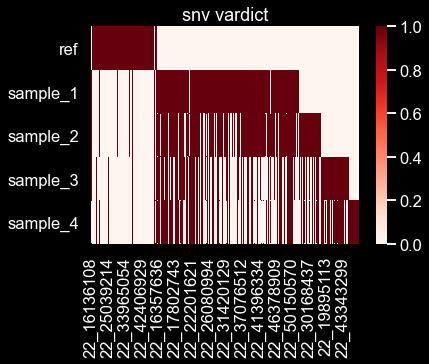

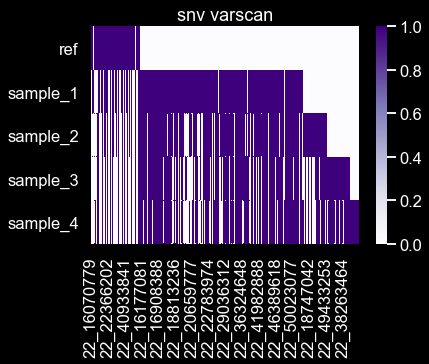

In [113]:
cmap_list=['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']
for i, ys in enumerate(y_series_list):
    plt.figure()
    sns.heatmap(ys, cmap=cmap_list[i])
    plt.title('snv' + ' ' + methods[i])
    plt.show()

<AxesSubplot:>

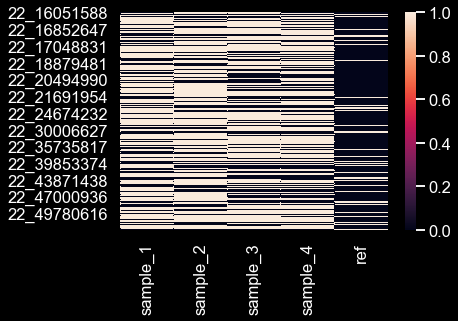

In [114]:
y_true
y_series = pd.concat(y_list[1:], axis=1)
y_series['ref'] = y_true
y_series.sort_index(inplace=True)
sns.heatmap(y_series, cbar="coolwarm")

# Caller robustness (consensus across at least 3 methods) with original Plasma Sample as reference

46906
(52394, 19)


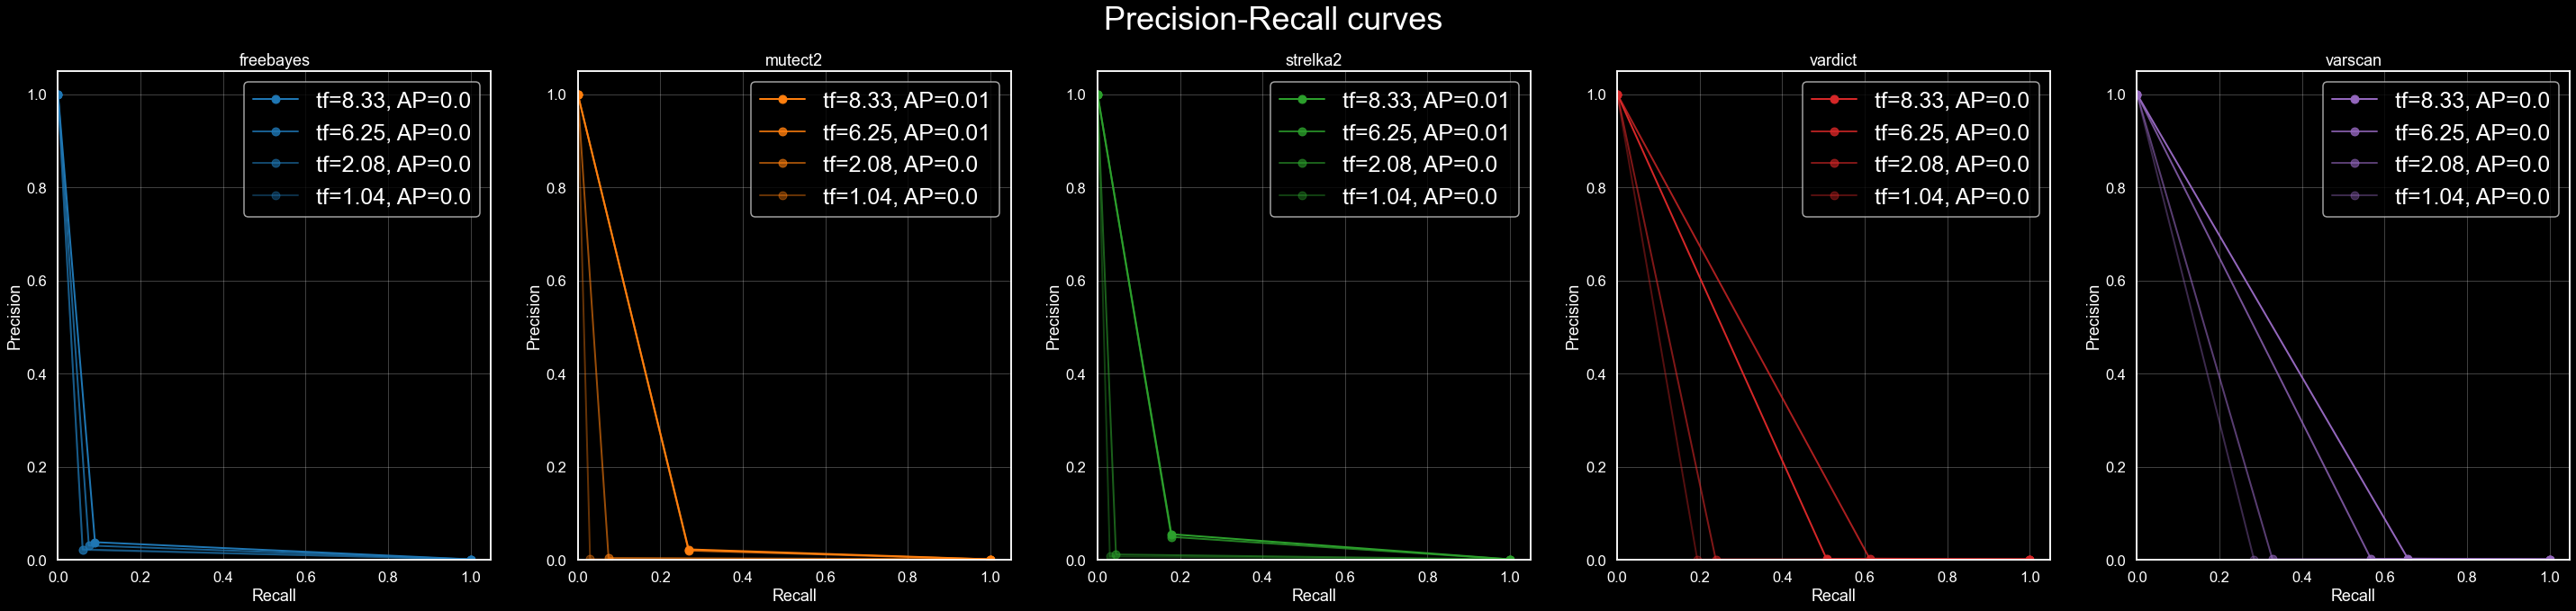

<Figure size 432x288 with 0 Axes>

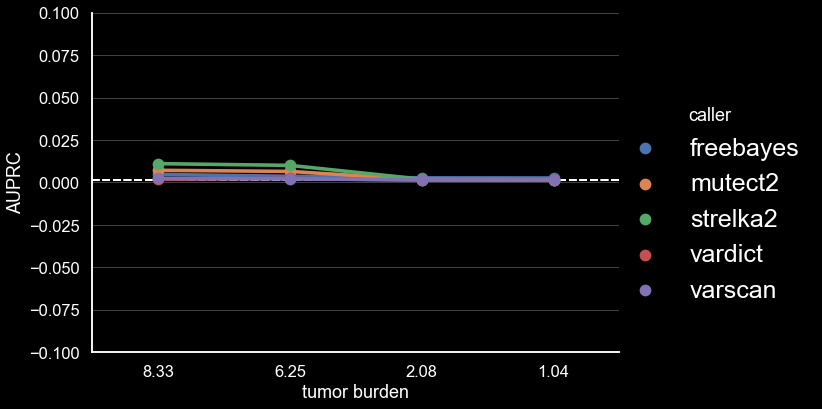

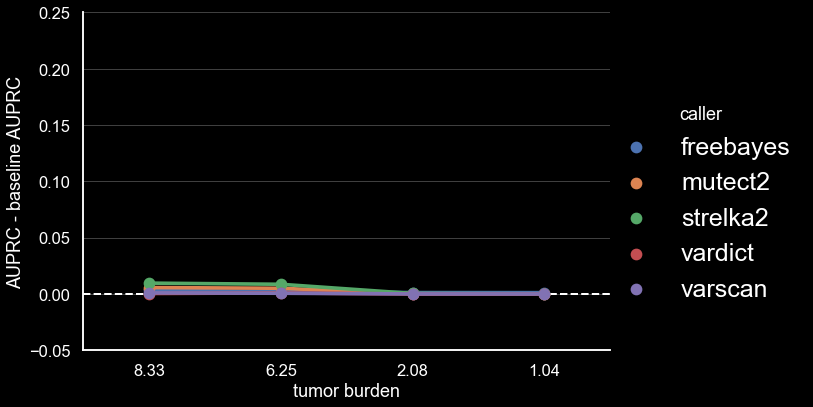

<Figure size 432x288 with 0 Axes>

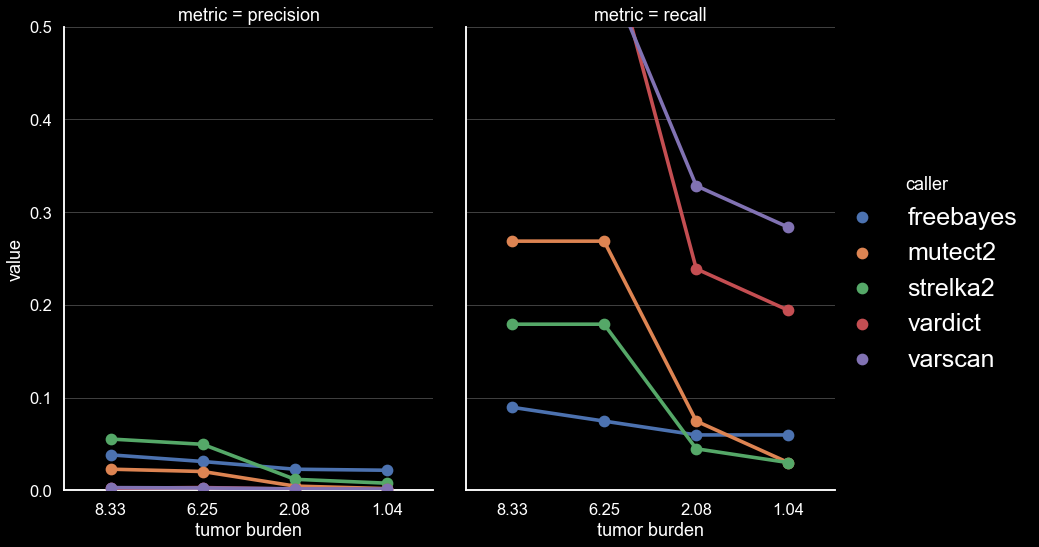

In [52]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    """nbmin = pd_methods[['QUAL_0', 'caller']].groupby('caller').count().min().values[0]
    print(nbmin)
    y_true = pd_methods[['sample_0', 'QUAL_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    indexlist = []
    for method in methods:
        a = y_true['QUAL_0'][y_true['caller'] == method].astype(float).nlargest(nbmin)
        indexlist += list(a.index)
        #vprint(len(a))
    indexlist = np.unique(indexlist)"""
    
    
    y_true = pd_methods[['sample_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_0'].sum()
    y_true[y_true <= 2] = 0
    #y_true = y_true.loc[indexlist]
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
       # y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([-0.1, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.05, 0.25])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

(-0.1, 0.1)

<Figure size 432x288 with 0 Axes>

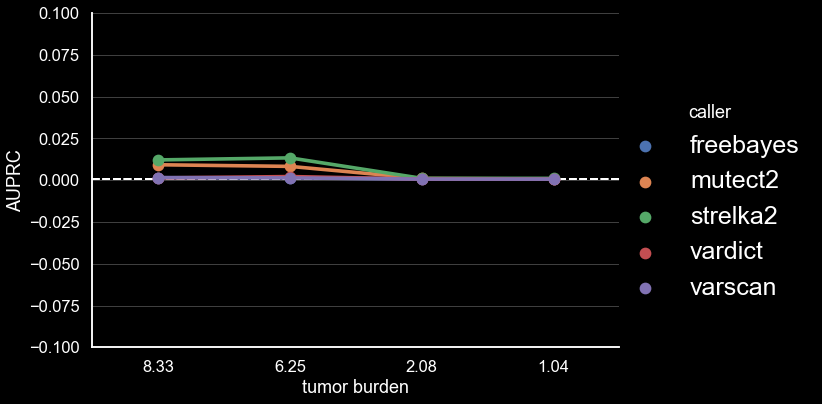

In [51]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([-0.1, 0.1])

# Within caller consistency with both original Plasma Sample as reference

In [74]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method][['sample_0', 'sample_0_bis']]
        y_true['ref'] = y_true['sample_0'] & y_true['sample_0_bis']
        y_true.index.name = 'CHROM_POS'
        y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
        y_true = y_true.astype(bool)
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

KeyboardInterrupt: 

# AUPRC with reference = SNV found in both undiluted plasma samples by at least 2 callers

42776
(44714, 25)


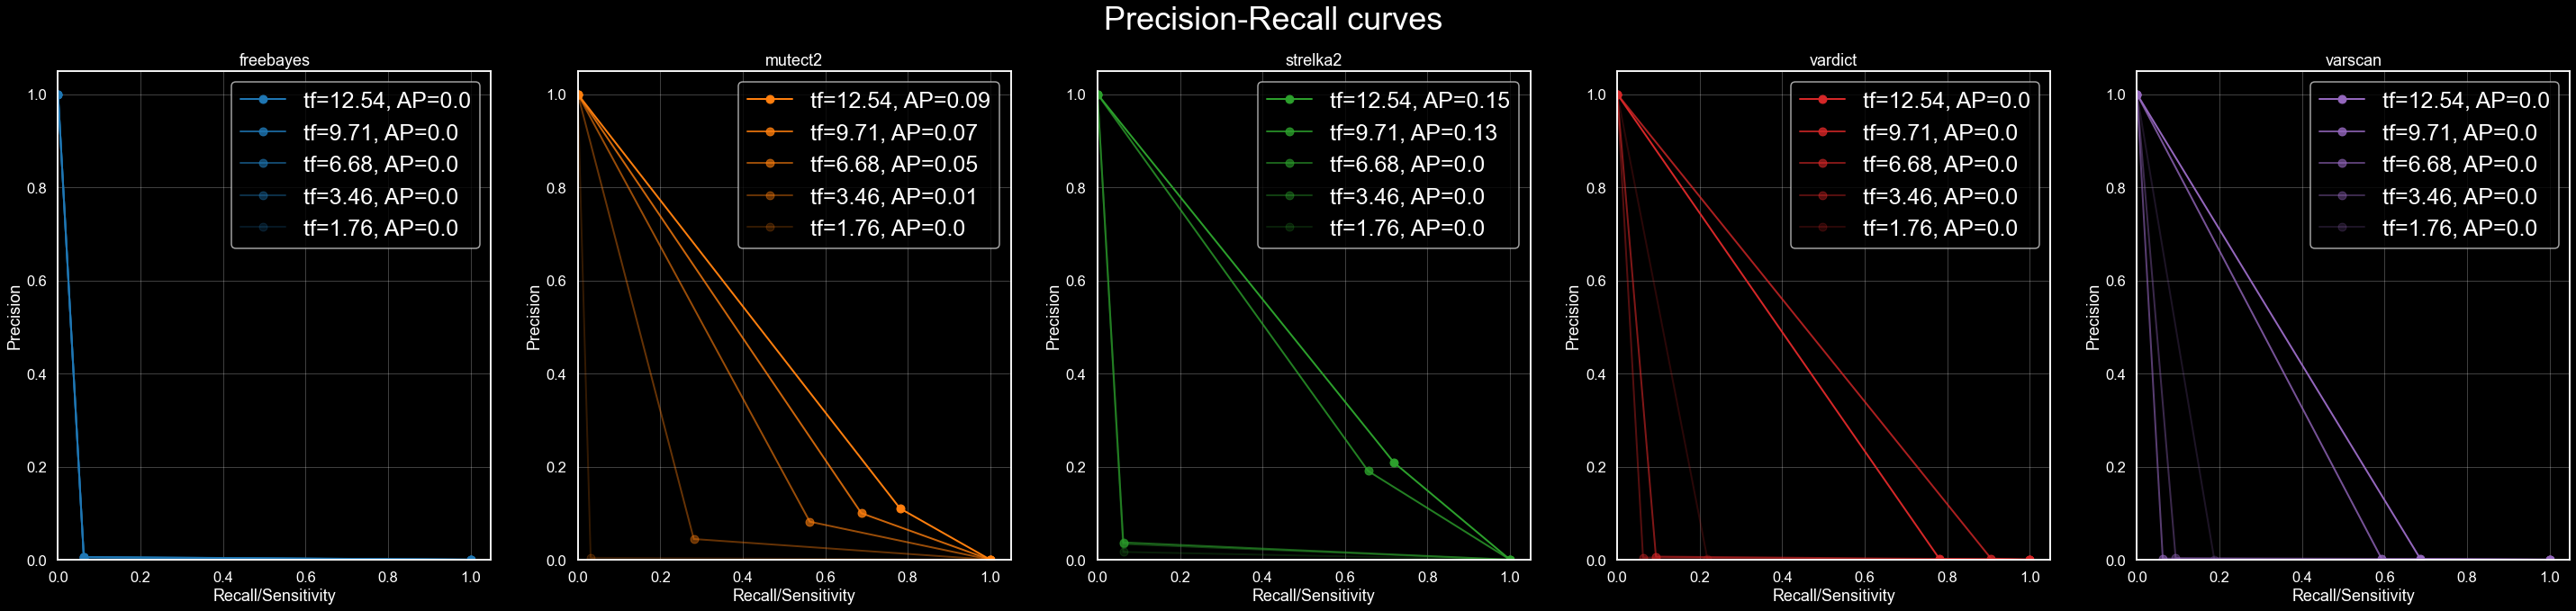

<Figure size 432x288 with 0 Axes>

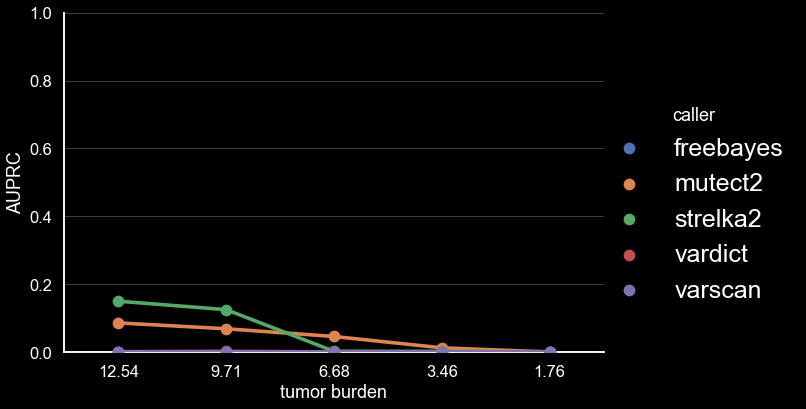

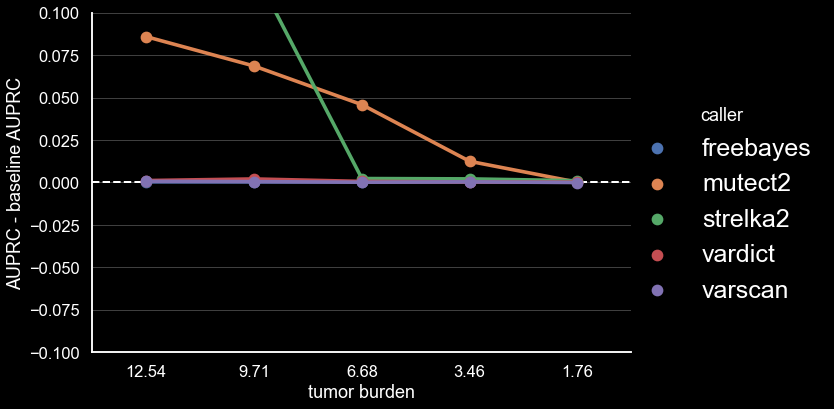

<Figure size 432x288 with 0 Axes>

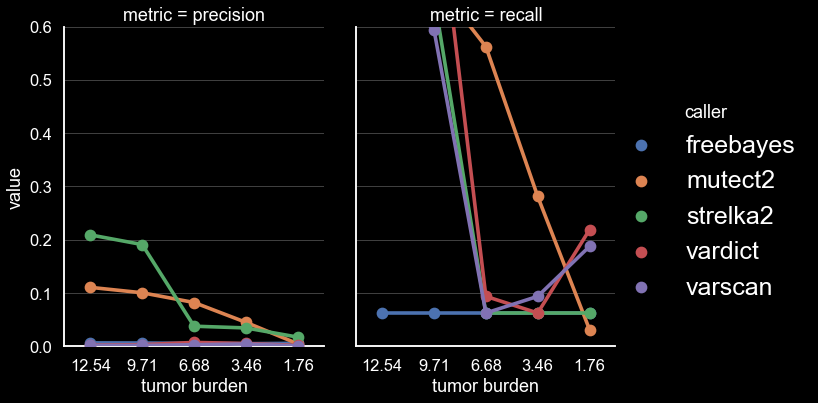

In [76]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'sample_0_bis', 'caller']]
    y_true['ref'] = pd_methods['sample_0'] & pd_methods['sample_0_bis']
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

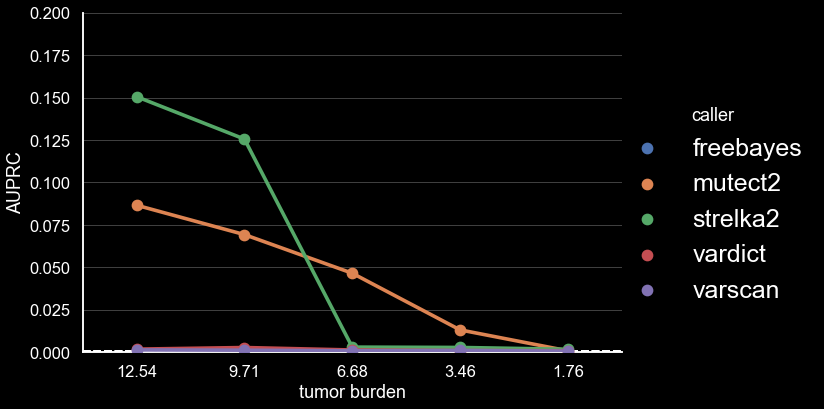

In [80]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([0, 0.2])

## AUPRC with reference = SNV found in the tumor by the same method

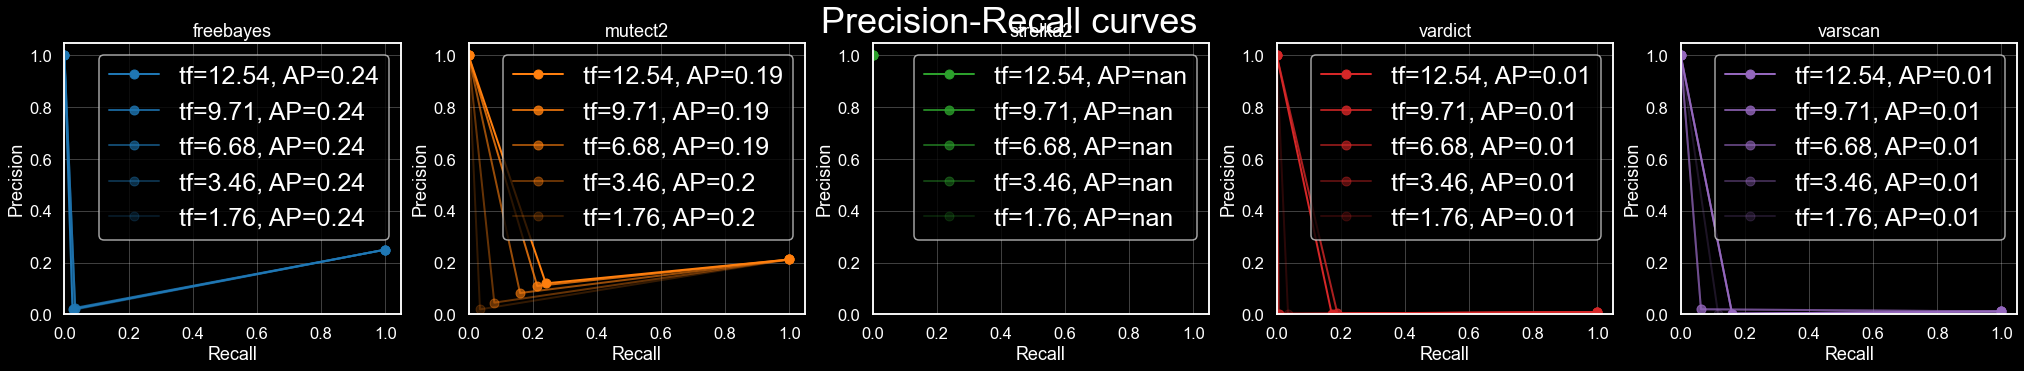

<Figure size 432x288 with 0 Axes>

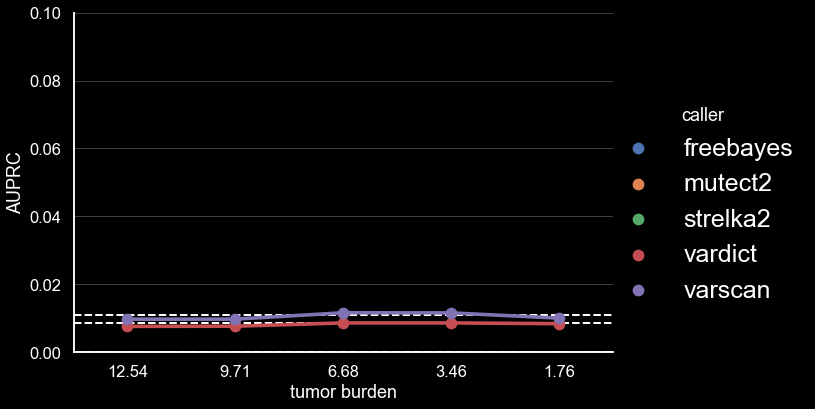

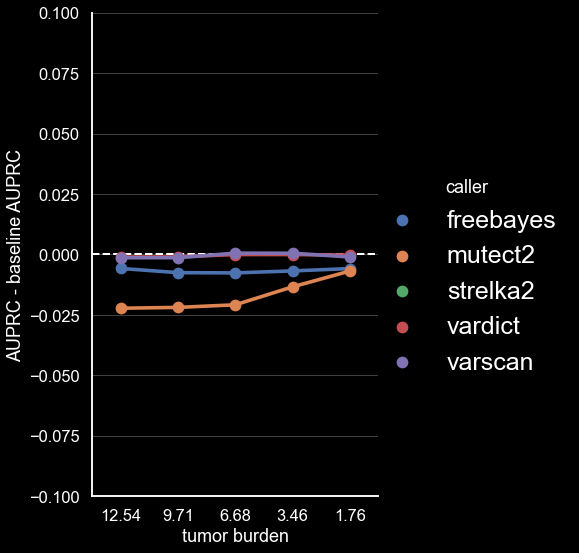

<Figure size 432x288 with 0 Axes>

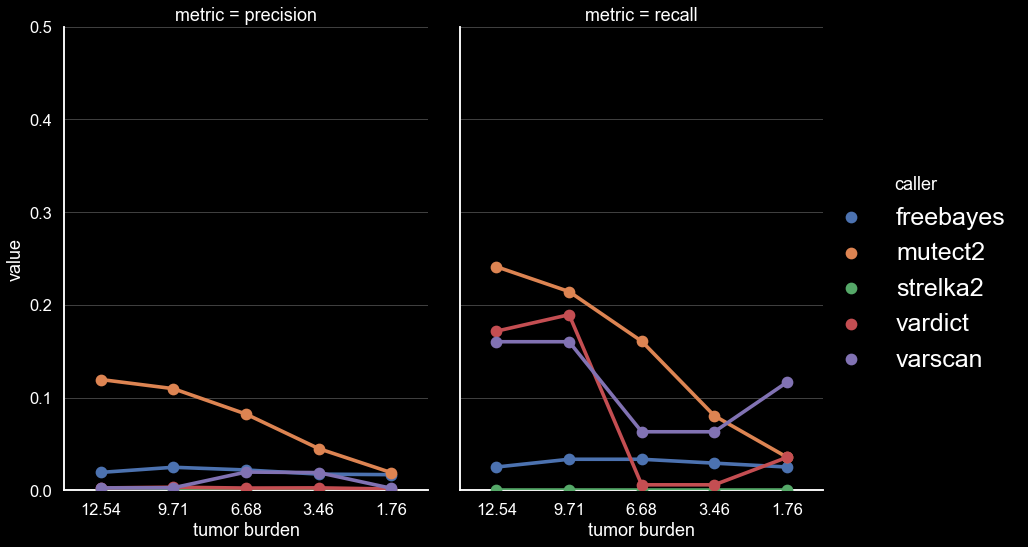

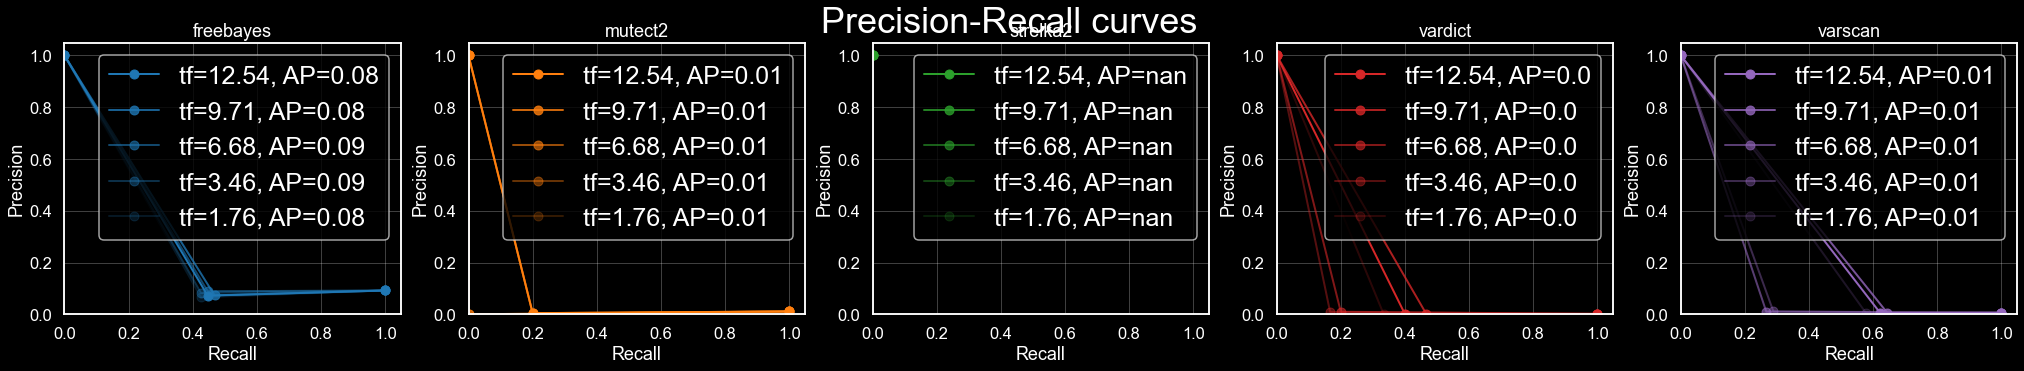

<Figure size 432x288 with 0 Axes>

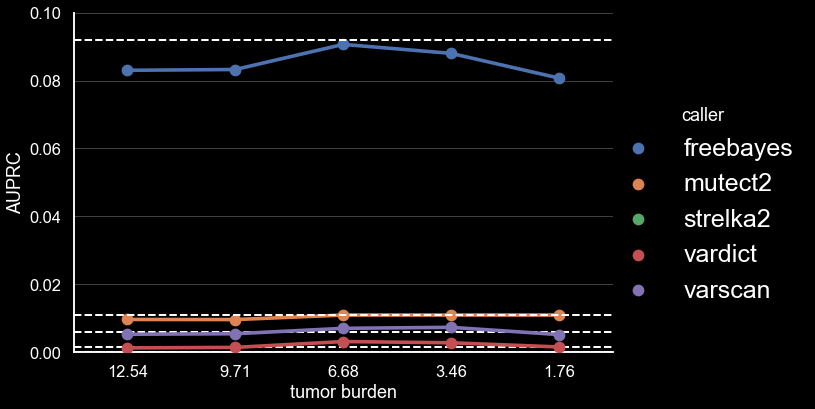

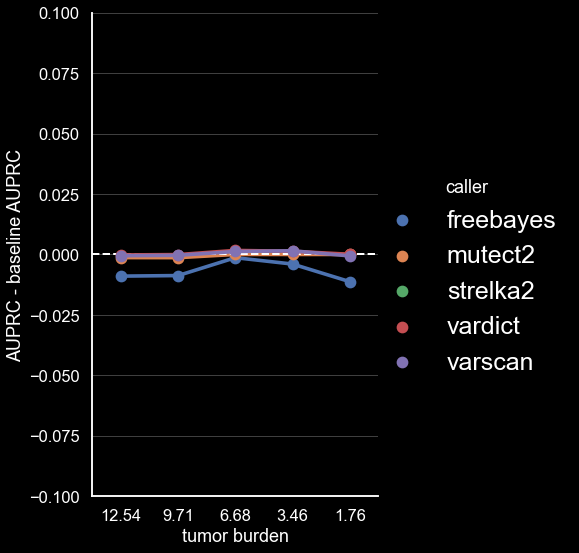

<Figure size 432x288 with 0 Axes>

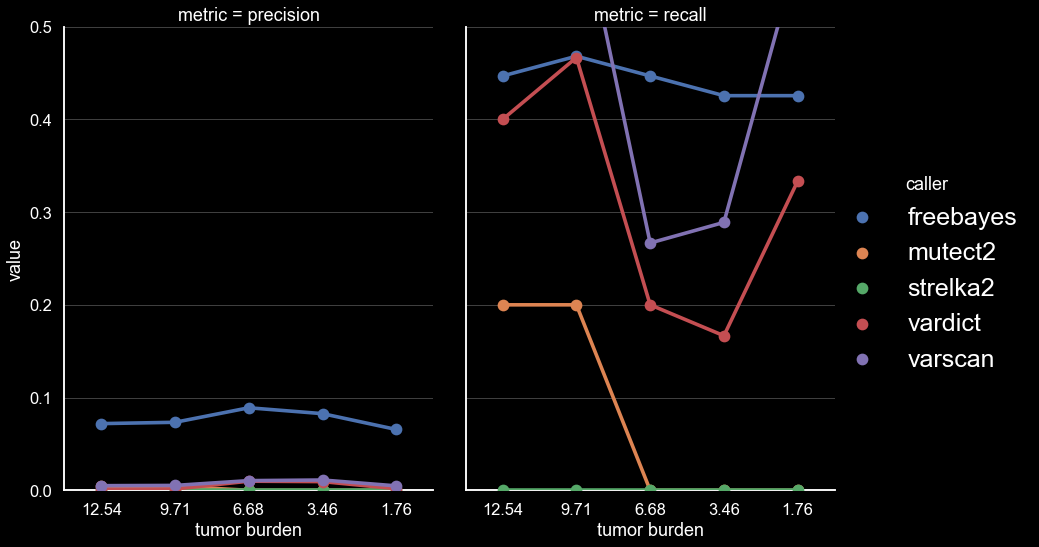

In [81]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_t'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

38069


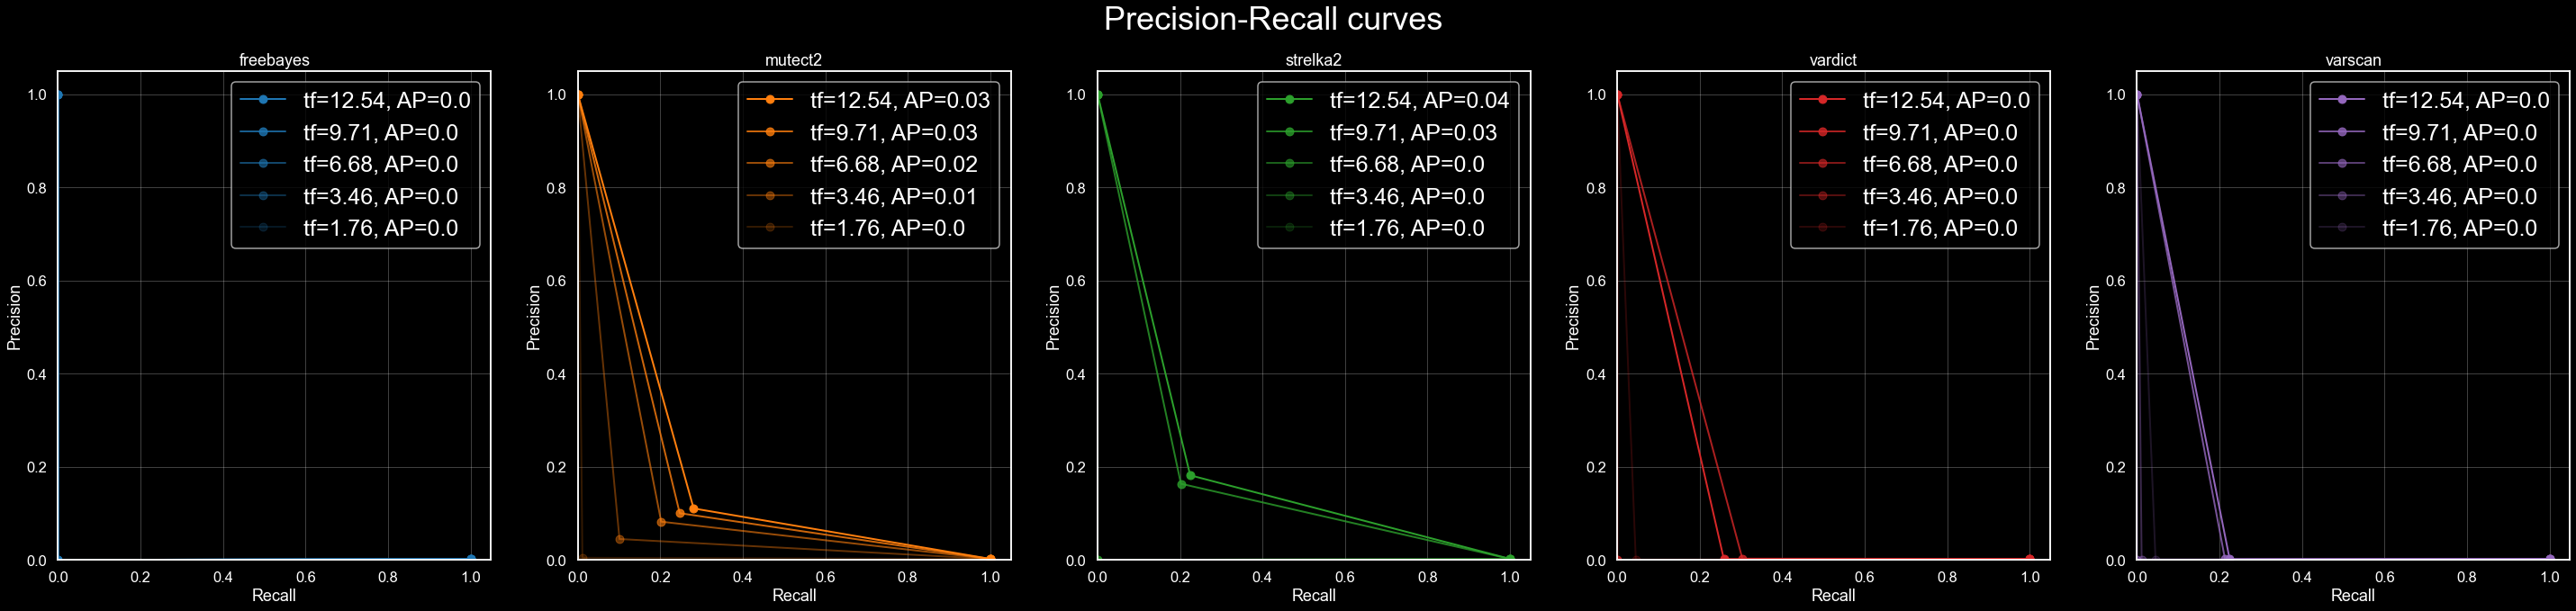

<Figure size 432x288 with 0 Axes>

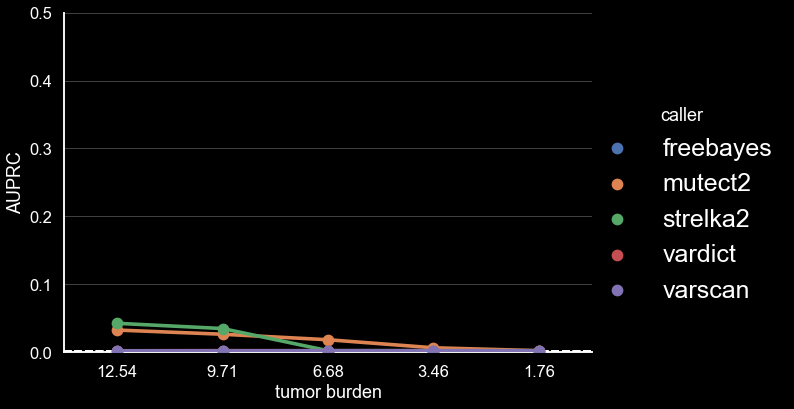

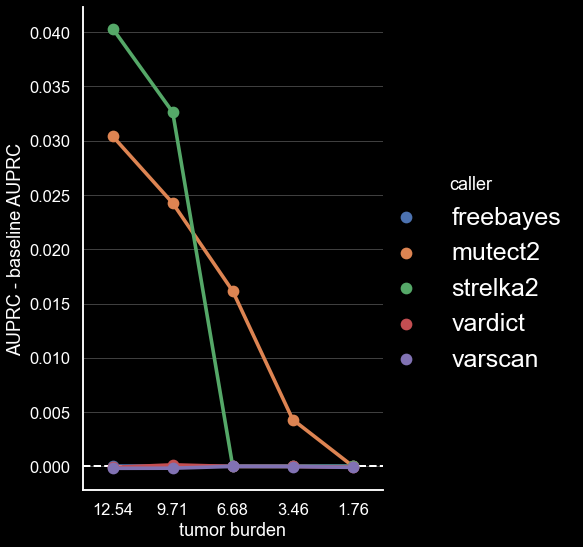

<Figure size 432x288 with 0 Axes>

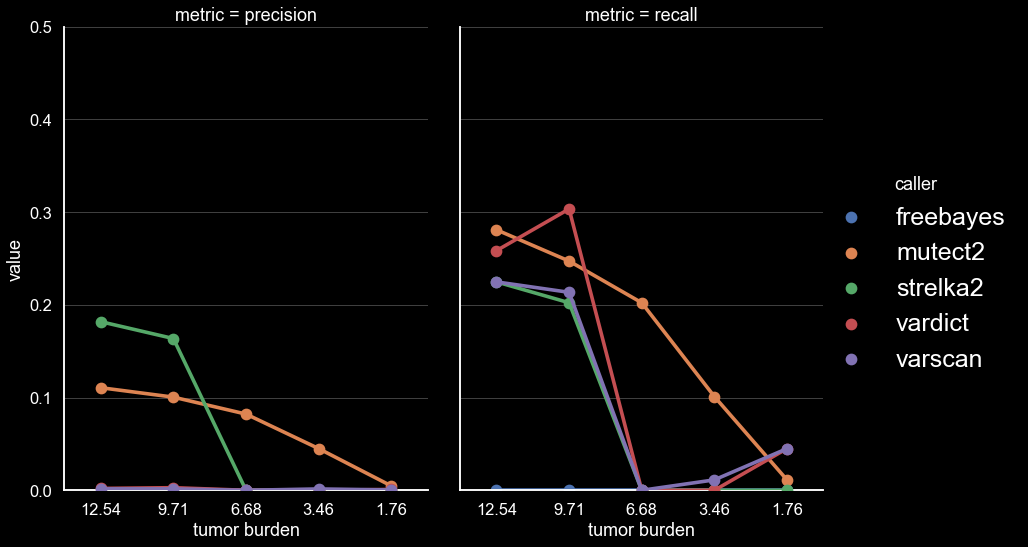

In [20]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.2])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

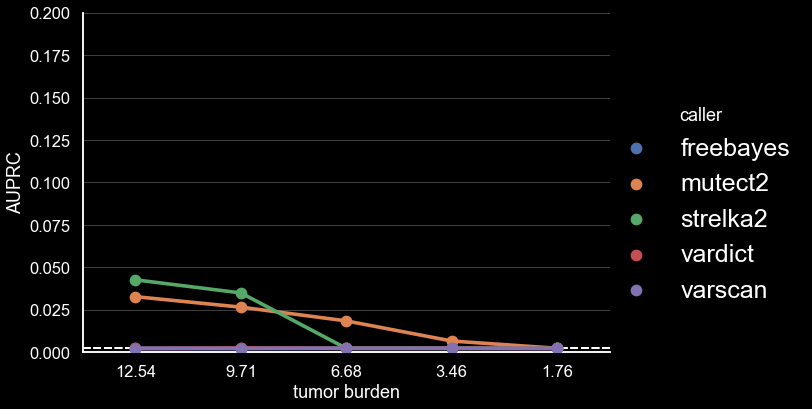

In [21]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([0, 0.2])

In [22]:
for mutation in ['snv']: #, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']):

        s0 = sample_0[['REF', 'ALT', 'QUAL', 'type', method]]
        s0.rename(columns = {method:'sample_0'},  inplace = True)
        st = sample_t[['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        s1 = sample_1[['REF', 'ALT', 'QUAL', 'type', method]]
        s1.rename(columns = {method:'sample_1'},  inplace = True)
        s2 = sample_2[['REF', 'ALT', 'QUAL', 'type', method]]
        s2.rename(columns = {method:'sample_2'},  inplace = True)
        s3 = sample_3[['REF', 'ALT', 'QUAL', 'type', method]]
        s3.rename(columns = {method:'sample_3'},  inplace = True)
        #s4 = sample_4[['REF', 'ALT', 'QUAL','type', method]]
        #s4.rename(columns = {method:'sample_4'},  inplace = True)
        #s5 = sample_5[['REF', 'ALT', 'QUAL','type', method]]
        #s5.rename(columns = {method:'sample_5'},  inplace = True)

        pd_method = pd.concat([s0.loc[~s0.index.duplicated()],
               st.loc[~st.index.duplicated()],
               s1.loc[~s1.index.duplicated()],
               s2.loc[~s2.index.duplicated()],
               s3.loc[~s3.index.duplicated()],
               s4.loc[~s4.index.duplicated()],
               s5.loc[~s5.index.duplicated()]], axis=1)

        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        pd_method.columns = ['REF', 'ALT', 'QUAL_0', 'type_0', 'sample_0','QUAL_t', 'type_t', 'sample_t', 'QUAL_1', 'type_1', 'sample_1', 'QUAL_2', 'type_2', 'sample_2',  'QUAL_3', 'type_3', 'sample_3', 'QUAL_4', 'type_4', 'sample_4', 'QUAL_5', 'type_5', 'sample_5']
        pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']] = pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].fillna(value=False)
        #pd_method.drop(pd_method[pd_method['sample_0'] + pd_method['sample_0_bis']+ pd_method['sample_1'] + pd_method['sample_2'] + pd_method['sample_3'] + pd_method['sample_4'] == False].index, axis=0, inplace=True)
        pd_method[['REF', 'sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].head()
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_0','type_t','type_1', 'type_2', 'type_3', 'type_4', 'type_5']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]

        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame.empty
    pd_results_PR = pd.DataFrame.empty
    count = 0

    fig, axs = plt.subplots(1,5,figsize=(30, 4))
    fig.suptitle('Precision-Recall curves')


    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])



    baselineAUPRC = {}

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool) + pd_methods[pd_methods['caller'] == method]['sample_0_bis'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)

        y_0 = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool).reindex(y_true.index).squeeze()
        y_0 = y_0.fillna(False)
        y_1 = pd_methods[pd_methods['caller'] == method]['sample_1'].astype(bool).reindex(y_true.index).squeeze()
        y_1 = y_1.fillna(False)
        y_2 = pd_methods[pd_methods['caller'] == method]['sample_2'].astype(bool).reindex(y_true.index).squeeze()
        y_2 = y_2.fillna(False)
        y_3 = pd_methods[pd_methods['caller'] == method]['sample_3'].astype(bool).reindex(y_true.index).squeeze()
        y_3 = y_3.fillna(False)
        y_4 = pd_methods[pd_methods['caller'] == method]['sample_4'].astype(bool).reindex(y_true.index).squeeze()
        y_4 = y_4.fillna(False)
        y_5 = pd_methods[pd_methods['caller'] == method]['sample_5'].astype(bool).reindex(y_true.index).squeeze()
        y_5 = y_5.fillna(False)

        res_df['AUPRC'] = [average_precision_score(y_true, y_0),
                          average_precision_score(y_true, y_1),
                          average_precision_score(y_true, y_2),
                          average_precision_score(y_true, y_3),
                          average_precision_score(y_true, y_4),
                          average_precision_score(y_true, y_5),
                         ]
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_0) - baselineAUPRC[method],
                      average_precision_score(y_true, y_1) - baselineAUPRC[method],
                      average_precision_score(y_true, y_2) - baselineAUPRC[method],
                      average_precision_score(y_true, y_3) - baselineAUPRC[method],
                      average_precision_score(y_true, y_4) - baselineAUPRC[method],
                      average_precision_score(y_true, y_5) - baselineAUPRC[method],

                     ]
        res_PR_df['precision'] = [precision_score(y_true, y_0),
                          precision_score(y_true, y_1),
                          precision_score(y_true, y_2),
                          precision_score(y_true, y_3),
                          precision_score(y_true, y_4),
                          precision_score(y_true, y_5),
                         ]

        res_PR_df['recall'] = [recall_score(y_true, y_0),
                          recall_score(y_true, y_1),
                          recall_score(y_true, y_2),
                          recall_score(y_true, y_3),
                          recall_score(y_true, y_4),
                          recall_score(y_true, y_5),
                         ]
        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method
        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, 6], inplace=True)

        # Plot Precision-Recall curve
        alpha_list = [0, 1, .8, .6, .4, .2, .1]
        for i in range(1,6):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results, legend=False)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0, 0.5])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

NameError: name 'sample_0' is not defined

- Histograms of true allele frequencies in each tumor sample. Note how increasing admixture increases the prevalence of low- frequency variants.
- Benchmarking results for germline SNVs
- Benchmarking results for somatic SNVs on exome data.
- averaged over the four replicates

- add fake mutations on healthy mixtures

In [39]:
cov_pd = pd.read_csv('../data/CRC-986_300316_cov.txt', header=None)
cov_pd.index = [i for i in range(1,1002)]
cov_pd

0
1     1880935
2     1312716
3     1171549
4     1492055
5     1900432
...       ...
997     15728
998     15821
999     16007
1000    16136
1001  8327761

[1001 rows x 1 columns]

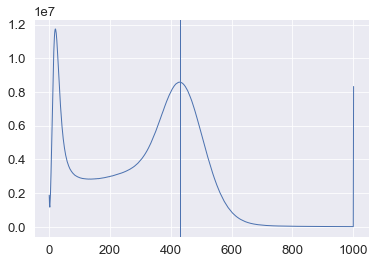

In [52]:
plt.plot(cov_pd.index, cov_pd.values)
plt.axvline(430)

In [43]:
cov_pd.describe()

0
count  1.001000e+03
mean   2.844013e+06
std    2.883503e+06
min    1.572800e+04
25%    5.442400e+04
50%    2.855419e+06
75%    4.320742e+06
max    1.174217e+07

([<matplotlib.axis.YTick at 0x7fb178a59b50>,
 [Text(0, 0.0, '0'),
  Text(0, 0.1, ''),
  Text(0, 0.2, ''),
  Text(0, 0.30000000000000004, ''),
  Text(0, 0.4, ''),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, ''),
  Text(0, 0.7000000000000001, ''),
  Text(0, 0.8, ''),
  Text(0, 0.9, ''),
  Text(0, 1.0, '1')])

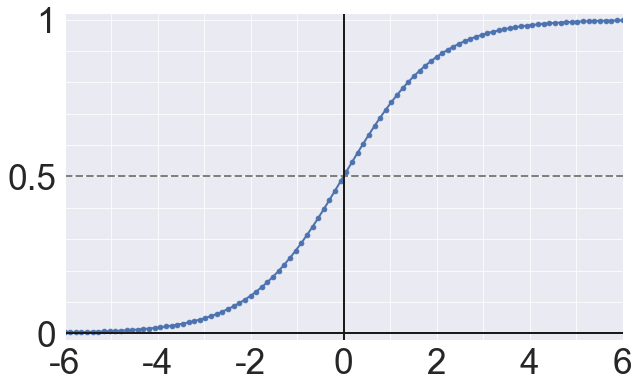

In [102]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0)) #, label='w=1, b=0')
#plt.scatter(x, sigmoid(x, 10, 0))
#plt.plot(x, sigmoid(x, 10, 0), lw=2, label='w=10, b=0')
#plt.scatter(x, sigmoid(x, 0.1, 0))
#plt.plot(x, sigmoid(x, 0.1, 0), lw=2, label='w=0.1, b=0')
#plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
#plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
#plt.xlabel('z')
#plt.ylabel('sigma(w.z+b)')
#plt.legend()

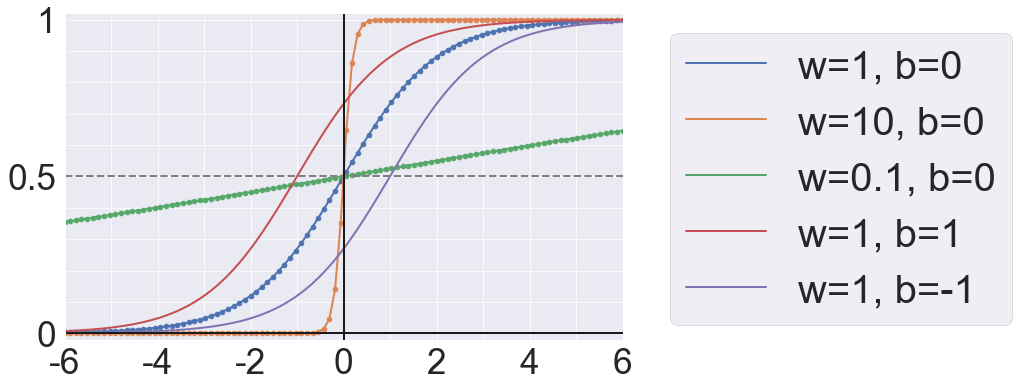

In [109]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 10, 0))
plt.plot(x, sigmoid(x, 10, 0), label='w=10, b=0')
plt.scatter(x, sigmoid(x, 0.1, 0))
plt.plot(x, sigmoid(x, 0.1, 0),  label='w=0.1, b=0')
plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

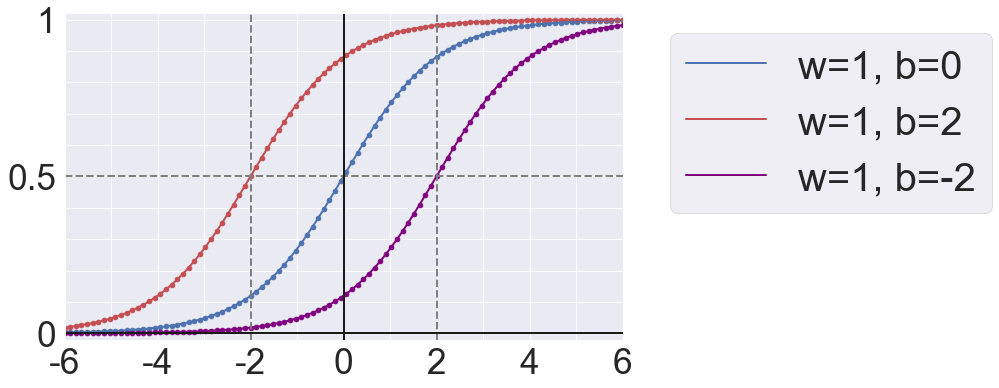

In [115]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 1, 2), c='r')
plt.plot(x, sigmoid(x, 1, 2), label='w=1, b=2', c='r')
plt.scatter(x, sigmoid(x, 1, -2), c='purple')
plt.plot(x, sigmoid(x, 1, -2), label='w=1, b=-2', c='purple')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(-2, c='grey', ls='--')
plt.axvline(2, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')